In [1]:
!pip uninstall torch -y &> /dev/null
!pip install torch==1.13.1 &> /dev/null

In [6]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import random_split

In [7]:
# Set the seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [8]:
class MlpNet(nn.Module):
    def __init__(self, width_ratio=-1):
        super(MlpNet, self).__init__()
        input_dim = 784 # [mnist] 28 x 28 x 1
        if width_ratio != -1:
            self.width_ratio = width_ratio
        else:
            self.width_ratio = 1

        self.fc1 = nn.Linear(input_dim, int(400/self.width_ratio), bias=not True)
        self.fc2 = nn.Linear(int(400/self.width_ratio), int(200/self.width_ratio), bias=not True)
        self.fc3 = nn.Linear(int(200/self.width_ratio), int(100/self.width_ratio), bias=not True)
        self.fc4 = nn.Linear(int(100/self.width_ratio), 10, bias=not True)
        self.enable_dropout = False

    def forward(self, x, disable_logits=True):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        if self.enable_dropout:
            x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        if self.enable_dropout:
            x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        if self.enable_dropout:
            x = F.dropout(x, training=self.training)
        x = self.fc4(x)

        if disable_logits:
            return x
        else:
            return F.log_softmax(x)

In [9]:
# Define the transform to apply to the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset, only keeping images of number 4
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [10]:
mnist.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
idx_not_fours = np.where(np.array(mnist.targets) != 4)[0]
dataset_not_fours = torch.utils.data.Subset(mnist, idx_not_fours)

In [12]:
dataset = torch.utils.data.DataLoader(dataset_not_fours, batch_size=32, shuffle=True)

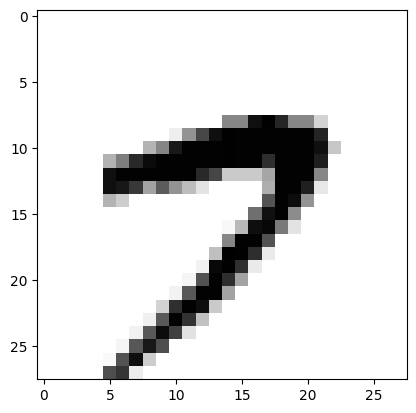

In [13]:
plt.imshow(dataset.dataset[81][0].numpy().squeeze(), cmap='gray_r');

In [14]:
dataset = dataset.dataset

In [15]:
# set the split ratio
train_ratio = 0.8
val_ratio = 0.2

# calculate the sizes of the training and validation sets
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# use random_split to split the Subset into train and validation subsets
training_data, test_data = random_split(dataset, [train_size, test_size])

In [35]:
# --------------
# HYPERPARAMETERS
lr = 0.0001
momentum = 0.9
batch_size = 64
epochs = 10
weight_decay = 0.001
# --------------
#print the hyperparameters in a table
print("Hyperparameters:")
print("lr: ",lr)
print("momentum: ",momentum)
print("batch_size: ",batch_size)
print("epochs: ",epochs)
print("weight_decay: ",weight_decay)

Hyperparameters:
lr:  0.0001
momentum:  0.9
batch_size:  64
epochs:  10
weight_decay:  0.001


In [36]:
model = MlpNet()

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [37]:
print("The traning set has ",len(training_data), "images.")
print("The test set has ",len(test_data), "images.")
print("The batch size is ",batch_size, ".")
print("There will be",int(len(training_data)/batch_size), "batches per epoch.")

The traning set has  43326 images.
The test set has  10832 images.
The batch size is  64 .
There will be 676 batches per epoch.


In [38]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Lenght of train_dataloader: 677
Lenght of test_dataloader: 170
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


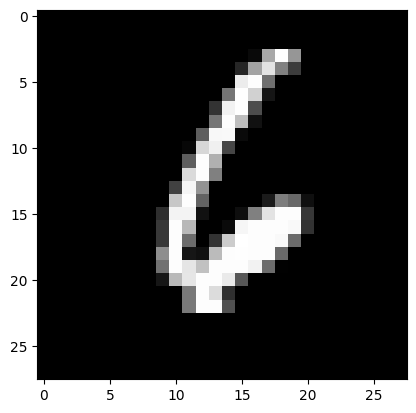

Label: 6


In [39]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Lenght of train_dataloader: {len(train_dataloader)}")
print(f"Lenght of test_dataloader: {len(test_dataloader)}")

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [40]:
def train_loop(dataloader, model, loss_fn, optimizer, plot_the_loss=True):
    size = len(dataloader.dataset)
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>4f}  [{current:>5d}/{size:>5d}]")

    if plot_the_loss:
        plt.plot(losses)
        plt.show()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [42]:
loss_fn = nn.CrossEntropyLoss()

for t in range(epochs):
    print(f"Epoch {t+1}:")
    train_loop(train_dataloader, model, loss_fn, optimizer, False)

test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1:
loss: 2.168167  [   64/43326]
loss: 2.175913  [  704/43326]
loss: 2.184946  [ 1344/43326]
loss: 2.194246  [ 1984/43326]
loss: 2.169518  [ 2624/43326]
loss: 2.180944  [ 3264/43326]
loss: 2.165131  [ 3904/43326]
loss: 2.172295  [ 4544/43326]
loss: 2.170720  [ 5184/43326]
loss: 2.164687  [ 5824/43326]
loss: 2.153788  [ 6464/43326]
loss: 2.167730  [ 7104/43326]
loss: 2.172362  [ 7744/43326]
loss: 2.153558  [ 8384/43326]
loss: 2.170492  [ 9024/43326]
loss: 2.153249  [ 9664/43326]
loss: 2.153173  [10304/43326]
loss: 2.158978  [10944/43326]
loss: 2.152077  [11584/43326]
loss: 2.137154  [12224/43326]
loss: 2.135778  [12864/43326]
loss: 2.129297  [13504/43326]
loss: 2.148001  [14144/43326]
loss: 2.136446  [14784/43326]
loss: 2.113287  [15424/43326]
loss: 2.131316  [16064/43326]
loss: 2.117888  [16704/43326]
loss: 2.149534  [17344/43326]
loss: 2.142998  [17984/43326]
loss: 2.120459  [18624/43326]
loss: 2.104902  [19264/43326]
loss: 2.126593  [19904/43326]
loss: 2.124002  [20544/43326]
l

In [43]:
#Save model
torch.save(model.state_dict(), "model_B.pth")

In [44]:
#Read the model
model_B = MlpNet()
model_B.load_state_dict(torch.load("model_B.pth"))
model_B.eval()
test_loop(test_dataloader, model_B, loss_fn)

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.378832 



In [45]:
GPU_USED = -1

def get_pretrained_model(path, data_separated=False):
    model = MlpNet()


    if GPU_USED != -1:
        state = torch.load(
            path, map_location=(
                lambda s, _: torch.serialization.default_restore_location(s, 'cuda:' + str(GPU_USED))
            ),)
    else:
        state = torch.load(
            path, map_location=(
                lambda s, _: torch.serialization.default_restore_location(s, 'cpu')
            ),)

    model_state_dict = state['model_state_dict']

    if 'test_accuracy' not in state:
        state['test_accuracy'] = -1

    if 'epoch' not in state:
        state['epoch'] = -1

    if not data_separated:
        print("Loading model at path {} which had accuracy {} and at epoch {}".format(path, state['test_accuracy'],
                                                                                  state['epoch']))
    else:
        print("Loading model at path {} which had local accuracy {} and overall accuracy {} for choice {} at epoch {}".format(path,
            state['local_test_accuracy'], state['test_accuracy'], state['choice'], state['epoch']))

    model.load_state_dict(model_state_dict)

    if GPU_USED != -1:
        model = model.cuda(GPU_USED)

    if not data_separated:
        return model, state['test_accuracy']
    else:
        return model, state['test_accuracy'], state['local_test_accuracy']

import os

args = None
model_A, accuracy_A = get_pretrained_model(os.path.join('mnist_models', 'model_{}/{}.checkpoint'.format(0, "final")))
test_loop(test_dataloader, model_A, loss_fn)

Loading model at path mnist_models/model_0/final.checkpoint which had accuracy 97.72 and at epoch 10
Accuracy of the model A is 97.72
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.040533 

